# Track 2: SIR Model and Flocking


## Modelling epidemic spread of disease with the SIR model

In the [SIR model](https://de.wikipedia.org/wiki/SIR-Modell) of disease spread agents have 3 basic states of infection. When agents have not yet contacted the disease they are susceptible for a possible infection ($S$). When they get infected ($I$) they can spread the disease to other susceptible agents in a given infection radius ($R_I$) with probability ($P_I$). In our immplementation, agents can only come out from an infected state 2 way (note that this can vary across model implementations). They either recover ($R$) with probability $P_R$ and get immune to future infections, or they die ($D$) with probability $P_D$)

In [ ]:
#first we install the package (in case it is not done yet) and import the Simulation class
%pip install -e .

In the following cell we again use the provided code base to explore the SIR(D) model. As before, agents move randomly in a self-propelled way with a given speed. Remember, inheritance can make it easy to use the "superpowers" of a class but add new ones on top. (Do you remember the Animal->Goat inheritance example?). We use inheritance here as well. We simply take the `AgentSelfPropelled` class that already implements the random movement of agent and we inherit from it with the class `AgentSIR`. In that we implement the infection states and the probabilistic spread of disease in a given radius of every agent. You can control the movement of agents and the disease spread with the pramaters provided in the below code snippet.

In [5]:
import numpy as np
from pygmodw23.sims import Simulation


# Simulation Parameters
# simulation time
T = 2000
# max visualization framerate (also depends on your computer)
framerate = 2000
# You can speed up the simulation a lot by turning off the visualization
# and simultaneously set the framerate to a very high value, e.g. 2000
with_visualization = True
# number of agents
N = 100

# how many timesteps should be saved (slightly slows simulation)
# You should have at least a few hundred MB free memory (RAM)
memory_length = T

# showing agent trajectories (significantly slows simulation)
show_agent_trails = False

# arena
width = height = 500
window_pad = 50

# Create a simulation instance
simulation = Simulation(N=N, T=T, agent_type="SIR-brownian-selfpropelled", framerate=framerate,
                        width=width, height=height, window_pad=window_pad, with_visualization=with_visualization)

# probability to make an agent moving other remain still
ratio_of_moving_agents = 1

# Change Agent Parameters
for agent in simulation.agents:
    agent.noise_type = "uniform"  # or "normal"
    
    # Agent movement parameters
    if np.random.rand() < ratio_of_moving_agents:
        agent.v_max = 2
        agent.noise_params = (-0.5, 0.5)  # (min, max) or (mean, std)
    else:
        agent.v_max = 0
        agent.noise_params = (0, 0)  # (min, max) or (mean, std)
    
    # SIR parameters
    agent.infection_prob =   0.05
    agent.recovery_prob =    0.001
    agent.death_prob =       0.001
    agent.infection_radius = 25
    agent.radius =           8


# Initially infecting some agents
num_infected_agents = 3
for agent in simulation.agents:
    if agent.id < num_infected_agents:
        agent.state = "I"
    else:
        break
        
    
# showing colorcoded trails if requested
simulation.show_agent_trails = show_agent_trails

# saving data if requested
simulation.save_agent_data = True

# saving data in last <memory_length> steps
simulation.memory_length = memory_length

# showing infective zone
simulation.show_zones = True


# Start the simulation
simulation.start()

Running simulation start method!
Starting main simulation loop!
2023-06-08_19-32-07.474494 Total simulation time:  10.022012


## Saving data to HDF5 files and visualizing disease spread

As before we can save the resulting data from the memory to HDF5 files. Additionally to the data in Track1, in this Track we can also save the states of the agents over time. Here is an example how:

In [7]:
# Import h5py and save ori_memory to hdf5 file
import h5py

# Create a single H5 file to contain our arrays
h5f = h5py.File('agent_states.h5', 'w')

# Save orientation and position memory (trails) into different datasets in the same file
h5f.create_dataset('agent_states', data=simulation.agent_states[:, ::-1])

# Close the file
h5f.close()

# Read saved data from HDF5 file
h5f = h5py.File('agent_states.h5','r')

# Read individual datasets into python variables
agent_states = h5f['agent_states'][:]

# close file after read
h5f.close()

# check if reading data was successful by printing array shapes 
print(f"Shape of readback state array: {agent_states.shape}")

Shape of readback state array: (100, 2000)


You can get inspired by this code snippet for later excercises when you will have to save data for many simulation runs to compare model parameters. Now we can proceed and visualize the dynamics of our SIR model pandemic. Let's first calculate what proportion of the whole population was in which state. In the `agent_states` array states (S, I, R, D) are encoded as integers (1, 2, 3, -1).

Text(0.5, 1.0, 'Temporal evolution of model pandemic with SIR(D) model')

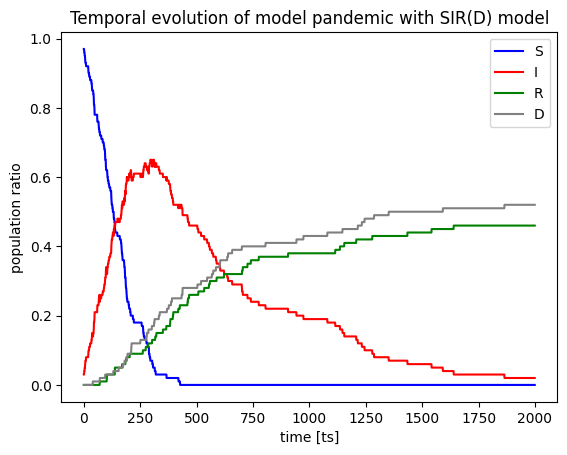

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Proportion of susceptible agents
susceptible_pop = [agent_states[:, t].tolist().count(1)/N for t in range(agent_states.shape[1])]
# Proportion of infected agents
infected_pop = [agent_states[:, t].tolist().count(2)/N for t in range(agent_states.shape[1])]
# Proportion of Recovered agents
recovered_pop = [agent_states[:, t].tolist().count(3)/N for t in range(agent_states.shape[1])]
# Proportion of Dead agents
dead_pop = [agent_states[:, t].tolist().count(-1)/N for t in range(agent_states.shape[1])]

plt.plot(susceptible_pop, c="blue", label="S")
plt.plot(infected_pop, c="red", label="I")
plt.plot(recovered_pop, c="green", label="R")
plt.plot(dead_pop, c="gray", label="D")

plt.legend()
plt.xlabel("time [ts]")
plt.ylabel("population ratio")
plt.title("Temporal evolution of model pandemic with SIR(D) model")

## Excercises for Track 2

  - Stop the agents from moving in the arena by setting `ratio_of_moving_agents = 0`. As we initialize the agents position randmly, the connection between agents (i.e. who can infect whom) will be controlled by their initial position and the `infection_radius`. Leave all other parameters fixed and change the agents `infection_radius` from 0, 10, 25, 50, 100. Observe how this affects the contagion dynamics.
  - Now set the infection radius to a relatively small value (e.g. 10). Note that with this infection radius disease spread is slow, simply because fixed position agents can only infect those neighbors that are closer than that. Allowing agents to move will change the game. Increase the proportion of moving agents by setting `ratio_of_moving_agents` between 0, 0.1, 0.25, 0.5, 1. Keep every other parameters fixed. What do you observe, how does the mobility of agents influence the disease spread?

# The Three-Zone-Model

Here, we will explore an agent-based model for simulating collective dynamics of animals (e.g. fish schools) through the provided package and small tasks. Feel free to provide your answers in this notebook. Our main task is the exploration of collective dynamics in a 2D model, related to the Three-Zone-Model (Two-Zone-Models) [by Couzin et al.](https://www.sciencedirect.com/science/article/pii/S0022519302930651), where the interaction between individuals is governed by three basic interactions: long-range attraction, short-ranged repulsion and alignment. 

## Brief Introduction
### Fundamental model

The code solves a set of (stochastic) differential equation describing a set of $N$ interacting agents ($i= 1,\dots, N$). The dynamics of each agent (in 2d) is described by the following equations of motion:

$$ \frac{d \vec{r}_i}{dt}=\vec{v}_i(t) $$
$$ \vec{v}_i(t) = {s_i\cos(\varphi_i(t)) \choose s_i\sin(\varphi_i(t)) } $$
$$ \frac{d \varphi_i}{dt} = \frac{1}{s_i}\left( F_{i,\varphi} + \eta_{i,\varphi} \right) $$


Here $\vec{r}_i$, $\vec{v}_i$ are the Cartesian position and velocity  vectors of the focal agent, wth $s_i$ being the (constant) speed of agent $i$. Furthermore, $\eta_{i,\varphi}$ represents Gaussian white noise introducing randomness in the motion of individuals, and $\vec{F}_{i,\varphi}$ is the projections of the total social force inducing a turning behavior.
$$ F_{i,\varphi}=\vec{F}_i \cdot \vec{u}_{\varphi,i} = \vec{F}_i {- s_i\sin\varphi_i \choose s_i\cos\varphi_i } $$


The total effective social force is a sum of three components:
$$ \vec{F}_i=\vec{F}_{i,rep}+\vec{F}_{i,alg}+\vec{F}_{i,att} $$


**Attraction:
$$\vec{F}_{i,att}=\sum_{j \in Neigh} +\mu_{att}S_{att}({r}_{ji}) \hat{r}_{ji} $$
Repulsion:
$$\vec{F}_{i,rep}=\sum_{j \in Neigh} -\mu_{rep}S_{rep}({r}_{ji}) \hat{r}_{ji}$$
Alignment:**
$$\vec{F}_{i,alg}=\sum_{j \in Neigh} \mu_{alg}S_{alg}({r}_{ji}) (\vec{v}_j-\vec{v}_i)$$
with $\hat r = \vec{r}/|r|$.

The strength of the different interactions is set by a constant $\mu_X$ and a sigmoid function of distance, which goes from 1 to 0, with the transition point at $r_{X,0}$ and steepness $a_{X}$:
$$ S_X(r)=\frac{1}{2}\left(\tanh(-a(r-r_{X,0})+1\right) $$

<img src="data/images/scheme_ranges.png" width='800'>

**Figure2.:** Local interaction forces around an agent

<img src="data/images/int_ranges.png">

**Figure1.:** Example of the 3 interaction zones around a focal agent

In [17]:
import numpy as np
from pygmodw23.sims import Simulation


# Simulation Parameters
# simulation time
T = 2000
# max visualization framerate (also depends on your computer)
framerate = 2000
# You can speed up the simulation a lot by turning off the visualization
# and simultaneously set the framerate to a very high value, e.g. 2000
with_visualization = True
# number of agents
N = 10

# how many timesteps should be saved (slightly slows simulation)
# You should have at least a few hundred MB free memory (RAM)
memory_length = T

# showing agent trajectories (significantly slows simulation)
show_agent_trails = False

# arena
width = height = 500
window_pad = 50

# Create a simulation instance
simulation = Simulation(N=N, T=T, agent_type="3zones", framerate=framerate,
                        width=width, height=height, window_pad=window_pad, with_visualization=with_visualization)


# we loop through all the agents of the created simulation
print("Setting parameters for agent", end = ' ')
# Change Agent Parameters
for agent in simulation.agents:
    print(f"{agent.id}", end = ', ')
    
    # changing angular noise (sigma)
    agent.noise_sig = 0.1
    
    # changing their default flocking parameters
    agent.s_att = 0.02  # attraction strength (AU)
    agent.s_rep = 5  # repulsion strength (AU)
    agent.s_alg = 10  # alignment strength (AU)

    agent.r_att = 200  # attraction range (px)
    agent.r_rep = 50  # repulsion range (px)
    agent.r_alg = 100  # alignment range (px)
    
    agent.steepness_att = -0.5  # steepness in attraction force calculation (sigmoid)
    agent.steepness_rep = -0.5  # steepness in repulsion force calculation (sigmoid)
    agent.steepness_alg = -0.5  # steepness in alignment force calculation (sigmoid)
    
    # changing maximum velocity and simulation timesteps
    agent.v_max = 2
    agent.dt = 0.05
        
    
# showing colorcoded trails if requested
simulation.show_agent_trails = show_agent_trails

# saving data if requested
simulation.save_agent_data = True

# saving data in last <memory_length> steps
simulation.memory_length = memory_length

# showing infective zone
simulation.show_zones = True


# Start the simulation
simulation.start()

Setting parameters for agent 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, Running simulation start method!
Starting main simulation loop!
2023-06-08_19-41-30.958539 Total simulation time:  11.529103


# TExcercises

Use the example code snippet above and modify it to answer the following questions. 

1. **Individual Dynamics**: Turn off all the interaction forces. Perform simulations with different angular noise values (noise_sig) and explore the behavior of the agents (you can try: 0.1, 1, 3). For the next tasks fix this parameter to 0.1.
2. **Obstacle Avoidance**:
    - a. Re-introduce a strong local repulsion interaction (`s_rep = 5`) and by that implement obstacle avoidance in a group of 10 agents. Set the repulsion steepness to -1.
    - b. Test the repulsion beahvior with different repulsion ranges (20, 50, 150). Feel free to move around the agents and see what happens when you move them in each others' repulsion zone.
    - c. **Hint:** You can visualize the zones around the agents with `z`. Only those zones will be shown for which the corresponding interaction strength is larger than zero. 
    - d. Explore the effect of the repulsion steepness (-0.1, -0.5, -1). When does repulsion take place with low or high steepness parameter? 
    - e. Do you think this obstacle avoidance will always avoid agents from collision?
    - f. For the upcoming experimentation fix repulsion strength to 5, steepness to -0.5 and range to 50
 
3. **Attraction-Repulsion**
    - a. Re-intorduce attraction and explore the beahavior with different attraction strenths 0.05, 0.5, 1, 5.
    - b. What happens for attraction strength of 0.05 and 5? What would you consider a realistic attraction strength for a mosquito swarm?
    - c. For the next experiment fix the attraction strength to 0.02, attraction range to 200 and steepness to -0.5.
    
4. **Movement Coordination**
    - a. What do you think you will observe when you introduce an intermediate zone where agents align to their neighbors?
    - b. Re-introduce the alignment zone by setting a strong alignment strength of 5. Is your observation matching with what you expected? What happens if you increase the attraction strength to 2?
    - c. Change back the attraction strength to 0.02. Introduce repellent walls by writing the following in the loop: `agent.boundary = "bounce_back"`. Is the system robust enough to handle such perturbations? Try different alignment strengths of 1.75 and 5. What is the difference? Try different angular noise values as well.